# Introduction

This document serves as a guide to introduce users to demonstrating impact of Ads in R with a real example used with Advertising data. 

In [19]:
library(CausalImpact)
library(tidyverse)
library(xts)

# Import data files

In [20]:
ad_impressions <- read_csv('C:/Users/User/Documents/DV360 ad impressions 20180901-20181231.csv')

head(ad_impressions)

Parsed with column specification:
cols(
  `DV360 Exchange (CM Model)` = col_character(),
  `DV360 Creative Name (CM Model)` = col_character(),
  Date = col_integer(),
  `DV360 Impressions` = col_integer()
)


DV360 Exchange (CM Model),DV360 Creative Name (CM Model),Date,DV360 Impressions
DoubleClick Ad Exchange,Beauty Addict + Instant Beauty,20181121,521554
DoubleClick Ad Exchange,Beauty Addict + Instant Beauty,20181120,435500
DoubleClick Ad Exchange,Beauty Addict + Instant Beauty,20181122,347243
DoubleClick Ad Exchange,Flaunting Divas,20181001,324399
DoubleClick Ad Exchange,Flaunting Divas,20181002,314448
DoubleClick Ad Exchange,Beauty Addict + Instant Beauty,20181123,312875


In [21]:
channel_grouping <- read_csv('C:/Users/User/Documents/Channel Grouping Sessions.csv')
head(channel_grouping)

Parsed with column specification:
cols(
  `Default Channel Grouping` = col_character(),
  Date = col_integer(),
  Sessions = col_integer()
)


Default Channel Grouping,Date,Sessions
(Other),20180807,5748
(Other),20180808,5175
(Other),20180809,4927
(Other),20180813,4458
(Other),20180810,4411
(Other),20180811,4333


Problem Statement: We want to know the impact of K-Addict campaign impressions on the number of sessions on K Bright website

Variables of interest in an experiment (those that are measured or observed) are called response or dependent variables. Other variables in the experiment that affect the response and can be set or measured by the experimenter are called predictor, explanatory, or independent variables. 

For example, you might want to determine the recommended baking time for a cake recipe. 

Predictor variables such as Baking time or oven temperature would affect the response (we would change or optimise these), which could be moisture level or thickness of the cake (the outcome that we would want to measure).

Datasets are obtained from Google Analytics, from 1 September 2018 to 31 December 2018

Response: date, Sessions (1 August 2018 - 31 December 2018) 

First group of users (Predictor 1): date, Impressions of Flaunting Divas campaign (1 Sept 2018 - 31 Oct 2018)

Second group of users (Predictor 2): date, Impressions of K-Bright Visitor campaign (optional)

http://www.dartistics.com/timeseries.html

Channels report: ChannelGrouping, Date, Sessions
Ad Impressions report: DV360 Exchange (CM Model), DV360 Creative Name (CM Model), Date, DV360 Impressions

# Further Data Processing

In [22]:
# Create Date-Time column
ad_impressions$Date <-  as.Date(as.character(ad_impressions$Date),format="%Y%m%d")
#ad_impressions$Date <-  as.POSIXct(ad_impressions$Date, format = "%Y%m/%d", #origin="SGT")

channel_grouping$Date <-  as.Date(as.character(channel_grouping$Date),format="%Y%m%d")
#channel_grouping$Date <-  as.POSIXct(channel_grouping$Date, format = "%Y%m/%d", #origin="SGT")

In [23]:
# Filter for the specific campaign that we want to test
ad_impressions_K_Addict <- ad_impressions %>% 
  filter(`DV360 Exchange (CM Model)` == 'DoubleClick Ad Exchange' &
           `DV360 Creative Name (CM Model)` == 'Flaunting Divas') %>% 
  select(-`DV360 Exchange (CM Model)`)

# remove unwanted columns and join datasets
channel_grouping_wide <- channel_grouping %>% 
  spread(`Default Channel Grouping`, Sessions)

ad_impressions_K_Addict_wide <- ad_impressions_K_Addict %>% 
  spread(`DV360 Creative Name (CM Model)`, `DV360 Impressions`)

channel_ad_impressions <- channel_grouping_wide %>% 
  left_join(ad_impressions_K_Addict_wide, by = 'Date') %>% 
   mutate_at(vars(-Date), funs(replace(., is.na(.), 0)))

channel_ad_impressions_xts <- xts(channel_ad_impressions[-1], order.by = as.Date(channel_ad_impressions$Date))

## data in order of response, predictor1, predictor2, etc.
model_data <- channel_ad_impressions_xts[,c("Display","Flaunting Divas","Paid Search")]


# Create Pre & Post Periods

In [24]:
# Determine pre and post event time frames varying post period timepre.period 
pre.period <- as.Date(c("2018-08-01","2018-08-31"))
post.period <- as.Date(c("2018-11-01","2018-12-31"))

# Run Causal Impact analysis and see results

In [25]:
impact_channel_ad_impressions_xts = CausalImpact(model_data, pre.period, post.period)
summary(impact_channel_ad_impressions_xts)

Posterior inference {CausalImpact}

                         Average         Cumulative      
Actual                   171             10418           
Prediction (s.d.)        1094 (150)      66729 (9168)    
95% CI                   [800, 1391]     [48809, 84853]  
                                                         
Absolute effect (s.d.)   -923 (150)      -56311 (9168)   
95% CI                   [-1220, -629]   [-74435, -38391]
                                                         
Relative effect (s.d.)   -84% (14%)      -84% (14%)      
95% CI                   [-112%, -58%]   [-112%, -58%]   

Posterior tail-area probability p:   0.00103
Posterior prob. of a causal effect:  99.89744%

For more details, type: summary(impact, "report")



# Generate a narrated report of the results

In [26]:
summary(impact_channel_ad_impressions_xts, "report")

Analysis report {CausalImpact}


During the post-intervention period, the response variable had an average value of approx. 170.79. By contrast, in the absence of an intervention, we would have expected an average response of 1093.91. The 95% interval of this counterfactual prediction is [800.14, 1391.04]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is -923.12 with a 95% interval of [-1220.25, -629.35]. For a discussion of the significance of this effect, see below.

Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully interpreted), the response variable had an overall value of 10.42K. By contrast, had the intervention not taken place, we would have expected a sum of 66.73K. The 95% interval of this prediction is [48.81K, 84.85K].

The above results are given in terms of absolute numbers. In relative terms, the resp

# Plot graphs of the results

Warning message:
"Removed 153 rows containing missing values (geom_path)."Warning message:
"Removed 306 rows containing missing values (geom_path)."

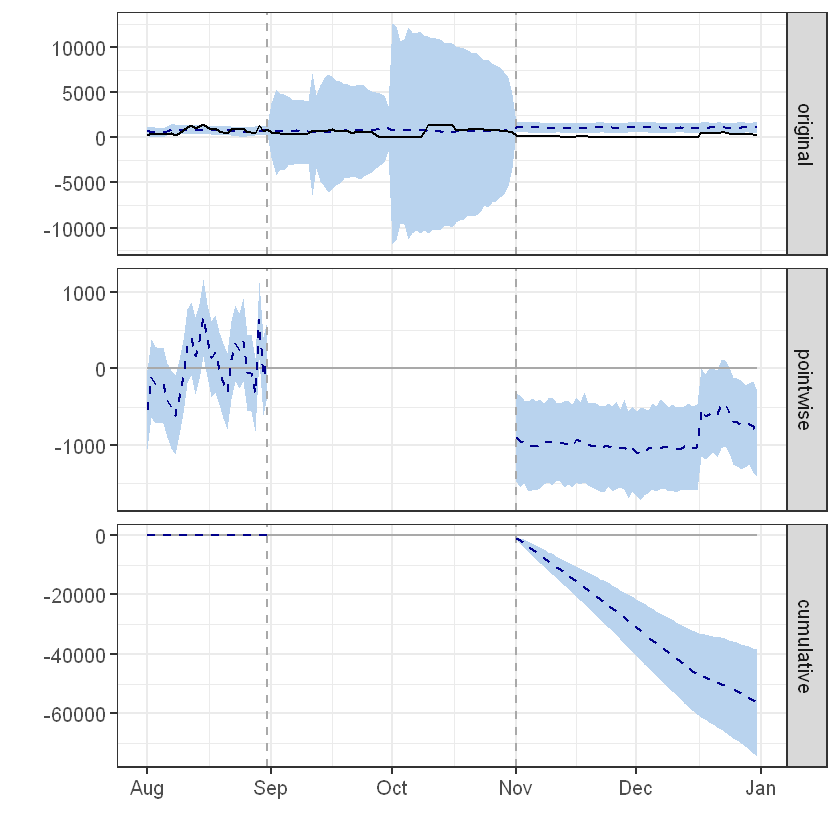

In [27]:
plot(impact_channel_ad_impressions_xts)

Original: Solid, black line is observed data before the intervention and dotted, blue line is the predicted coin in values for what would have occurred without the intervention

Pointwise: The net difference between the observed and predicted response on the original scale, or the difference between the solid, black line and the dotted, blue line on the original graph.

Cumulative: Dotted, blue line is the individual causal effects added up in time, day after day.

For all three graphs, the light blue shaded area represents the results in a 95% confidence level. The farther that the graph extends past the beginning of the intervention, the less certain of the causal effect; hence, the larger the shaded area.

# Show the predictor variables used in the model

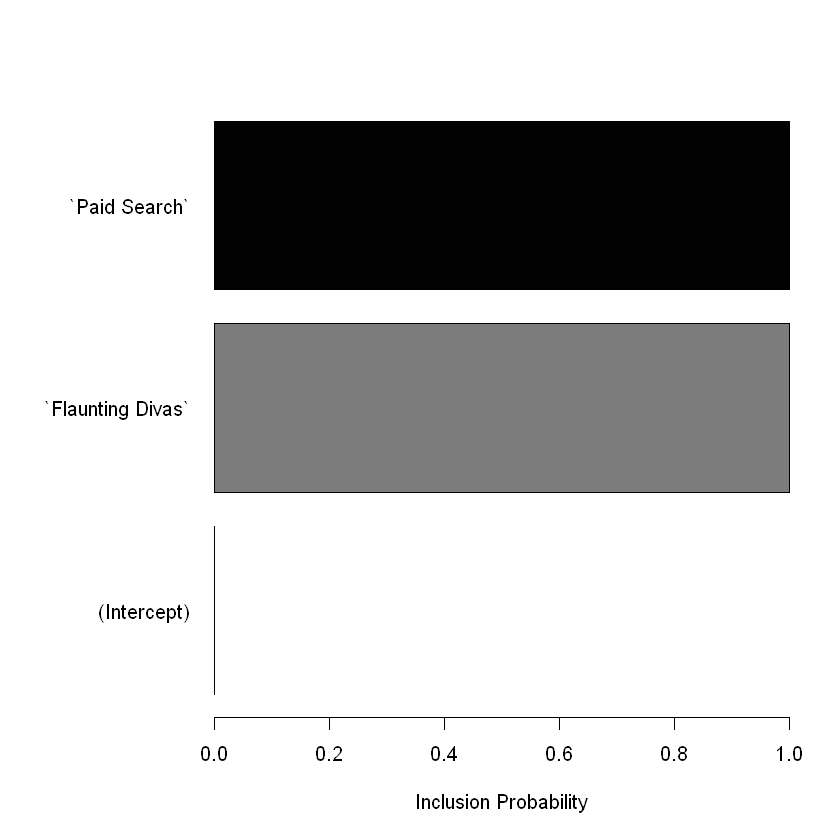

In [28]:
plot(impact_channel_ad_impressions_xts$model$bsts.model, "coefficients")

# Further exploration

https://ee.cooper.edu/~keene/assets/Neema_Thesis_vFinal.pdf